# Прекод

# Сборный проект-4

Вам поручено разработать демонстрационную версию поиска изображений по запросу.

Для демонстрационной версии нужно обучить модель, которая получит векторное представление изображения, векторное представление текста, а на выходе выдаст число от 0 до 1 — покажет, насколько текст и картинка подходят друг другу.

### Описание данных

Данные находятся [здесь](https://code.s3.yandex.net/datasets/dsplus_integrated_project_4.zip).

В файле `train_dataset.csv` собрана информация, необходимая для обучения: имя файла изображения, идентификатор описания и текст описания. Для одной картинки может быть доступно до 5 описаний. Идентификатор описания имеет формат `<имя файла изображения>#<порядковый номер описания>`.

В папке `train_images` содержатся изображения для тренировки модели.

В файле `CrowdAnnotations.tsv` — данные по соответствию изображения и описания, полученные с помощью краудсорсинга. Номера колонок и соответствующий тип данных:

1. Имя файла изображения.
2. Идентификатор описания.
3. Доля людей, подтвердивших, что описание соответствует изображению.
4. Количество человек, подтвердивших, что описание соответствует изображению.
5. Количество человек, подтвердивших, что описание не соответствует изображению.

В файле `ExpertAnnotations.tsv` содержатся данные по соответствию изображения и описания, полученные в результате опроса экспертов. Номера колонок и соответствующий тип данных:

1. Имя файла изображения.
2. Идентификатор описания.

3, 4, 5 — оценки трёх экспертов.

Эксперты ставят оценки по шкале от 1 до 4, где 1 — изображение и запрос совершенно не соответствуют друг другу, 2 — запрос содержит элементы описания изображения, но в целом запрос тексту не соответствует, 3 — запрос и текст соответствуют с точностью до некоторых деталей, 4 — запрос и текст соответствуют полностью.

В файле `test_queries.csv` находится информация, необходимая для тестирования: идентификатор запроса, текст запроса и релевантное изображение. Для одной картинки может быть доступно до 5 описаний. Идентификатор описания имеет формат `<имя файла изображения>#<порядковый номер описания>`.

В папке `test_images` содержатся изображения для тестирования модели.

## 1. Исследовательский анализ данных

Наш датасет содержит экспертные и краудсорсинговые оценки соответствия текста и изображения.

В файле с экспертными мнениями для каждой пары изображение-текст имеются оценки от трёх специалистов. Для решения задачи вы должны эти оценки агрегировать — превратить в одну. Существует несколько способов агрегации оценок, самый простой — голосование большинства: за какую оценку проголосовала большая часть экспертов (в нашем случае 2 или 3), та оценка и ставится как итоговая. Поскольку число экспертов меньше числа классов, может случиться, что каждый эксперт поставит разные оценки, например: 1, 4, 2. В таком случае данную пару изображение-текст можно исключить из датасета.

Вы можете воспользоваться другим методом агрегации оценок или придумать свой.

В файле с краудсорсинговыми оценками информация расположена в таком порядке: 

1. Доля исполнителей, подтвердивших, что текст **соответствует** картинке. 
2. Количество исполнителей, подтвердивших, что текст **соответствует** картинке.
3. Количество исполнителей, подтвердивших, что текст **не соответствует** картинке.

После анализа экспертных и краудсорсинговых оценок выберите либо одну из них, либо объедините их в одну по какому-то критерию: например, оценка эксперта принимается с коэффициентом 0.6, а крауда — с коэффициентом 0.4.

Ваша модель должна возвращать на выходе вероятность соответствия изображения тексту, поэтому целевая переменная должна иметь значения от 0 до 1.


In [385]:
import urllib.request
import zipfile
import os.path
import nltk
import numpy as np
import pandas as pd
import os
import torch
import torch.nn as nn
import pickle
import matplotlib.pyplot as plt
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision.io import read_image
from torchvision.models import resnet18, ResNet18_Weights
from torchvision.models.feature_extraction import create_feature_extractor
from PIL import Image
from pathlib import Path
from tqdm import tqdm
from transformers import AutoTokenizer, AutoModel
from sklearn.model_selection import GroupShuffleSplit
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

In [386]:
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\a-krasnov\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\a-krasnov\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

Определим список `констант` 

In [387]:
# ссылка на скачивание данных
DATA_URL='https://code.s3.yandex.net/datasets/dsplus_integrated_project_4.zip'
ROOT_FOLDER='./dsplus_integrated_project_4'
# исключаем повторную загрузку, если файл уже был ранее загружен
OUT_FILE=os.path.exists(ROOT_FOLDER + '.zip')
TRAIN_IMAGE_FOLDER=ROOT_FOLDER + '/to_upload/train_images'
TEST_IMAGE_FOLDER=ROOT_FOLDER + '/to_upload/test_images'
RANDOM_STATE=12345
TMP='./cache'

In [388]:
# cjplаём временный каталог
Path(TMP).mkdir(parents=True, exist_ok=True)

### Загрузка данных

In [389]:
if OUT_FILE == False:
    # скачиваем архив
    urllib.request.urlretrieve(DATA_URL, 'dsplus_integrated_project_4.zip')
    # распаковываем
    with zipfile.ZipFile('./dsplus_integrated_project_4.zip', 'r') as zip_ref:
        zip_ref.extractall(ROOT_FOLDER)

### Изучение данных

In [390]:
train_dataset_csv = pd.read_csv(ROOT_FOLDER + '/to_upload/train_dataset.csv')

train_dataset_csv.info()

train_dataset_csv.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5822 entries, 0 to 5821
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image       5822 non-null   object
 1   query_id    5822 non-null   object
 2   query_text  5822 non-null   object
dtypes: object(3)
memory usage: 136.6+ KB


,image,query_id,query_text
0,1056338697_4f7d7ce270.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...
1,1262583859_653f1469a9.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...
2,2447284966_d6bbdb4b6e.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...
3,2549968784_39bfbe44f9.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...
4,2621415349_ef1a7e73be.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...


#### Краудсорсинг

In [391]:
crowd_annotations_tsv = pd.read_csv(ROOT_FOLDER + '/to_upload/CrowdAnnotations.tsv', 
                                    sep='\t', 
                                    header=None, 
                                    names=['image', 'query_id', 'positive', 'n1', 'n2'])

crowd_annotations_tsv.info()

crowd_annotations_tsv.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47830 entries, 0 to 47829
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   image     47830 non-null  object 
 1   query_id  47830 non-null  object 
 2   positive  47830 non-null  float64
 3   n1        47830 non-null  int64  
 4   n2        47830 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 1.8+ MB


,image,query_id,positive,n1,n2
0,1056338697_4f7d7ce270.jpg,1056338697_4f7d7ce270.jpg#2,1.0,3,0
1,1056338697_4f7d7ce270.jpg,114051287_dd85625a04.jpg#2,0.0,0,3
2,1056338697_4f7d7ce270.jpg,1427391496_ea512cbe7f.jpg#2,0.0,0,3
3,1056338697_4f7d7ce270.jpg,2073964624_52da3a0fc4.jpg#2,0.0,0,3
4,1056338697_4f7d7ce270.jpg,2083434441_a93bc6306b.jpg#2,0.0,0,3


Описание колонок:
* `image` - Имя файла изображения;
* `query_id` - Идентификатор описания;
* `positive` - Доля людей, подтвердивших, что описание соответствует изображению;
* `n1` - Количество человек, подтвердивших, что описание соответствует изображению;
* `n2` - Количество человек, подтвердивших, что описание не соответствует изображению.

#### Оценка экспертов

In [392]:
expert_annotations_tsv = pd.read_csv(ROOT_FOLDER + '/to_upload/ExpertAnnotations.tsv', 
                                     sep='\t', 
                                     header=None, 
                                     names=['image', 'query_id', 'n1', 'n2', 'n3'])

expert_annotations_tsv.reset_index(inplace=True, drop=True)

expert_annotations_tsv.info()

expert_annotations_tsv.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5822 entries, 0 to 5821
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   image     5822 non-null   object
 1   query_id  5822 non-null   object
 2   n1        5822 non-null   int64 
 3   n2        5822 non-null   int64 
 4   n3        5822 non-null   int64 
dtypes: int64(3), object(2)
memory usage: 227.5+ KB


,image,query_id,n1,n2,n3
0,1056338697_4f7d7ce270.jpg,2549968784_39bfbe44f9.jpg#2,1,1,1
1,1056338697_4f7d7ce270.jpg,2718495608_d8533e3ac5.jpg#2,1,1,2
2,1056338697_4f7d7ce270.jpg,3181701312_70a379ab6e.jpg#2,1,1,2
3,1056338697_4f7d7ce270.jpg,3207358897_bfa61fa3c6.jpg#2,1,2,2
4,1056338697_4f7d7ce270.jpg,3286822339_5535af6b93.jpg#2,1,1,2


Описание колонок:
* `image` - Имя файла изображения;
* `query_id` - Идентификатор описания;
* `n1` — оценка 1 эксперта;
* `n2` — оценка 2 эксперта;
* `n3` — оценка 3 эксперта.

Выполним обработку данных краудсорсинга:
* добавим колонку `n0` с агрегированной оценкой;
* добавим колонку `positive` с долей, подтвердивших, что описание соотвествует изображению.

Эксперты ставят оценки по шкале от `1` до `4`, где 
* `1` — изображение и запрос совершенно не соответствуют друг другу;
* `2` — запрос содержит элементы описания изображения, но в целом запрос тексту не соответствует; 
* `3` — запрос и текст соответствуют с точностью до некоторых деталей;
* `4` — запрос и текст соответствуют полностью.

___Примечание___: "положительными" будем считать оценки `3` и `4`

In [393]:
# выполним обработку данных краудсорсинга
def calc_avg(row):
    """
    Вычисление результата "голосования" способом большинства
    
    Параметры:
    ----------
    row: Series
    
    Результат:
    ----------
    int - число
    """
    array = [row['n1'], row['n2'], row['n3']]
    u, c = np.unique(array, return_counts=True)

    # находим самую частую оценку
    y = u[c == c.max()]
    # вычисляем долю найденных оценок
    percentages = dict(zip(u, c / len(array)))
    
    # "позитивными" будем считать, тех у кого оценка 3 или 4
    row['n0'] = y[0] if len(y) == 1 else 0
    row['positive'] = percentages[y[0]] if len(y) == 1 and y[0] in [3, 4] else 0
    
    return row

In [394]:
expert_annotations_tsv = expert_annotations_tsv.apply(calc_avg, axis=1)

In [395]:
# удалим те мнения экспертов, где они полностью разошлись
expert_annotations_n0 = expert_annotations_tsv[expert_annotations_tsv['n0'] == 0]

display(expert_annotations_n0.head())

expert_annotations_tsv.drop(expert_annotations_n0.index, inplace=True)

,image,query_id,n1,n2,n3,n0,positive
17,1082379191_ec1e53f996.jpg,1536774449_e16b1b6382.jpg#2,1,2,3,0,0.0
40,1119015538_e8e796281e.jpg,2534502836_7a75305655.jpg#2,2,3,4,0,0.0
47,1122944218_8eb3607403.jpg,3325497914_f9014d615b.jpg#2,2,3,4,0,0.0
168,1287475186_2dee85f1a5.jpg,2918769188_565dd48060.jpg#2,1,2,3,0,0.0
199,1329832826_432538d331.jpg,1536774449_e16b1b6382.jpg#2,1,2,3,0,0.0


In [396]:
expert_annotations_tsv.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5696 entries, 0 to 5821
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   image     5696 non-null   object 
 1   query_id  5696 non-null   object 
 2   n1        5696 non-null   int64  
 3   n2        5696 non-null   int64  
 4   n3        5696 non-null   int64  
 5   n0        5696 non-null   int64  
 6   positive  5696 non-null   float64
dtypes: float64(1), int64(4), object(2)
memory usage: 356.0+ KB


### Объединение оценок

In [397]:
# для удобства установим индексы
crowd_annotations_tsv.set_index(['image', 'query_id'], inplace=True)
expert_annotations_tsv.set_index(['image', 'query_id'], inplace=True)

In [398]:
annotations = crowd_annotations_tsv[['positive']].merge(
    expert_annotations_tsv[['positive']], 
    how='outer', # используем это объединение, так как нужно соеденить все данные независимо от ключа
    left_index=True, 
    right_index=True, 
    suffixes=('_crowd', '_expert')
)

In [399]:
def join_positive_expert_priority(row):
    """
    Объединение оценок с приоритетом для экспертов
    
    Параметры:
    ----------
    row: Series
    
    Результат:
    ----------
    int - число
    """
    crowd = row['positive_crowd']
    expert = row['positive_expert']
    
    if expert >= 0:
        # важны только экспертные мнения
        return 1 if expert > 0.5 else 0
    
    # если эксперты не давали оценку, а результат есть на кроудсорсинге
    if crowd >= 0 and expert != expert:
        return 1 if crowd > 0.5 else 0
    
    return 0

In [400]:
annotations['positive'] = annotations.apply(join_positive_expert_priority, axis=1)

In [401]:
annotations.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 51268 entries, ('1056338697_4f7d7ce270.jpg', '1056338697_4f7d7ce270.jpg#2') to ('997722733_0cb5439472.jpg', '997722733_0cb5439472.jpg#2')
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   positive_crowd   47830 non-null  float64
 1   positive_expert  5696 non-null   float64
 2   positive         51268 non-null  int64  
dtypes: float64(2), int64(1)
memory usage: 1.4+ MB


In [402]:
annotations['positive'].value_counts()

0    48179
1     3089
Name: positive, dtype: int64

In [403]:
train_dataset_csv.set_index(['image', 'query_id'], inplace=True)

In [436]:
train_dataset = train_dataset_csv.merge(annotations, how='left', left_index=True, right_index=True)

In [437]:
# проверяем наличие данных
train_dataset['positive'].value_counts()

0.0    4957
1.0     810
Name: positive, dtype: int64

In [406]:
train_dataset.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 5822 entries, ('1056338697_4f7d7ce270.jpg', '2549968784_39bfbe44f9.jpg#2') to ('968081289_cdba83ce2e.jpg', '2292406847_f366350600.jpg#2')
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   query_text  5822 non-null   object 
 1   positive    5767 non-null   float64
dtypes: float64(1), object(1)
memory usage: 322.9+ KB


## 2. Проверка данных

В некоторых странах, где работает ваша компания, действуют ограничения по обработке изображений: поисковым сервисам и сервисам, предоставляющим возможность поиска, запрещено без разрешения родителей или законных представителей предоставлять любую информацию, в том числе, но не исключительно тексты, изображения, видео и аудио, содержащие описание, изображение или запись голоса детей. Ребёнком считается любой человек, не достигший 16 лет.

В вашем сервисе строго следуют законам стран, в которых работают. Поэтому при попытке посмотреть изображения, запрещённые законодательством, вместо картинок показывается дисклеймер:

> This image is unavailable in your country in compliance with local laws
> 

Однако у вас в PoC нет возможности воспользоваться данным функционалом. Поэтому все изображения, которые нарушают данный закон, нужно удалить из обучающей выборки.

In [407]:
stop_words = [
    'baby', 
    'child', 
    'little boy', 
    'little girl', 
    'kid', 
    'young girl', 
    'young boy', 
    'boy', 
    'girl'
]

In [408]:
def ban(txt):
    """
    Определение наличие стоп-слов
    
    Параметры:
    ----------
    txt: string - текст для анализа
    
    Результат:
    ----------
    boolean - результат обработки
    """
    txt = txt.lower()
    lemmatizer = WordNetLemmatizer()
    word_tokens = word_tokenize(txt)
    lemmatized_output = ' '.join([lemmatizer.lemmatize(w) for w in word_tokens])
    
    for word in stop_words:
        word_len = len(word.split())
        
        if word_len > 1:
            if word in txt:
                return True
        elif word_len == 1:
            if word in txt.split():
                return True
        
    return False

In [409]:
train_dataset['ban'] = train_dataset['query_text'].apply(ban)

train_dataset[train_dataset['ban'] == True].info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 1200 entries, ('1056338697_4f7d7ce270.jpg', '2549968784_39bfbe44f9.jpg#2') to ('757046028_ff5999f91b.jpg', '2061144717_5b3a1864f0.jpg#2')
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   query_text  1200 non-null   object 
 1   positive    1185 non-null   float64
 2   ban         1200 non-null   bool   
dtypes: bool(1), float64(1), object(1)
memory usage: 104.7+ KB


In [410]:
train_dataset.drop(train_dataset[train_dataset.ban == True].index, inplace=True)

train_dataset.drop(columns=['ban'], inplace=True)

## 3. Векторизация изображений

Перейдём к векторизации изображений.

Самый примитивный способ — прочесть изображение и превратить полученную матрицу в вектор. Такой способ нам не подходит: длина векторов может быть сильно разной, так как размеры изображений разные. Поэтому стоит обратиться к свёрточным сетям: они позволяют "выделить" главные компоненты изображений. Как это сделать? Нужно выбрать какую-либо архитектуру, например ResNet-18, посмотреть на слои и исключить полносвязные слои, которые отвечают за конечное предсказание. При этом можно загрузить модель данной архитектуры, предварительно натренированную на датасете ImageNet.

In [411]:
# Step 1: Initialize the model with the best available weights
weights = ResNet18_Weights.DEFAULT
model = resnet18(weights=weights)
model.eval()

# Step 2: Initialize the inference transforms
preprocess = weights.transforms()

# Step 3: Create the feature extractor with the required nodes
return_nodes = {'flatten': 'flatten'}
feature_extractor = create_feature_extractor(model, return_nodes=return_nodes)

In [412]:
def get_image_vector(image_path):
    """
    Получение вектора изображения
    
    Параметры:
    ----------
    image_path: string - путь к изображению
    
    Результат:
    ----------
    torch.Tensor
    """

    # Step 4: Load the image(s) and apply inference preprocessing transforms
    image = read_image(image_path).unsqueeze(0)
    model_input = preprocess(image)
    
    with torch.no_grad():
        # Step 5: Extract the features
        features = feature_extractor(model_input)
        flatten_fts = features["flatten"].squeeze()
        return flatten_fts.detach().numpy()

In [413]:
get_image_vector(TRAIN_IMAGE_FOLDER + '/53043785_c468d6f931.jpg').shape

C:\Users\a-krasnov\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


(512,)

In [414]:
# словарь для хранения результата обработки
image_vectors = {}

In [415]:
def images2vector(folder):
    count = 0
    
    for p in Path(folder).glob('*.jpg'):
        count+=1
        
    with tqdm(total=count) as pbar:
        for p in Path(folder).glob('*.jpg'):
            image_vectors[p.name] = get_image_vector(folder + f'/{p.name}')
            
            pbar.update(1)

In [416]:
# используем кэш
if os.path.exists(TMP + '/image_vectors.pickle'):
    image_vectors = pickle.load(open(TMP + '/image_vectors.pickle', 'rb'))
else:
    images2vector(TRAIN_IMAGE_FOLDER)
    pickle.dump(image_vectors, file = open(TMP + '/image_vectors.pickle', 'wb'))

In [417]:
img1 = list(image_vectors.keys())[0]
image_vectors[img1].shape

(512,)

In [418]:
print(f'''Векторизация изображения на заранее обученной модели resnet18 позволило сделать вектор длинной {image_vectors[img1].shape[0]}
Уменьшение вектора позволит сэкономить ресурсы и вычислительное время при обучении.''') 

Векторизация изображения на заранее обученной модели resnet18 позволило сделать вектор длинной 512
Уменьшение вектора позволит сэкономить ресурсы и вычислительное время при обучении.


## 4. Векторизация текстов

Следующий этап — векторизация текстов. Вы можете поэкспериментировать с несколькими способами векторизации текстов:

- tf-idf
- word2vec
- \*трансформеры (например Bert)

\* — если вы изучали трансформеры в спринте Машинное обучение для текстов.


In [419]:
# обучать будем на специальной модели 
tokenizer = AutoTokenizer.from_pretrained('distilbert-base-uncased')
model = AutoModel.from_pretrained('distilbert-base-uncased')

In [420]:
#Mean Pooling - Take attention mask into account for correct averaging
def mean_pooling(model_output, attention_mask):
    token_embeddings = model_output[0] #First element of model_output contains all token embeddings
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    sum_embeddings = torch.sum(token_embeddings * input_mask_expanded, 1)
    sum_mask = torch.clamp(input_mask_expanded.sum(1), min=1e-9)
    return sum_embeddings / sum_mask

In [421]:
def text2vector(sentences):
    #Tokenize sentences
    encoded_input = tokenizer(sentences, padding=True, truncation=True, max_length=128, return_tensors='pt')

    #Compute token embeddings
    with torch.no_grad():
        model_output = model(**encoded_input)

    #Perform pooling. In this case, mean pooling
    sentence_embeddings = mean_pooling(model_output, encoded_input['attention_mask'])

    pbar.update(1)
    return sentence_embeddings[0].detach().numpy()

In [422]:
# используем кэш
if os.path.exists(TMP + '/train_dataset.pickle'):
    train_dataset = pickle.load(open(TMP + '/train_dataset.pickle', 'rb'))
else:
    with tqdm(total=train_dataset.shape[0]) as pbar:
        train_dataset['text2vec'] = train_dataset['query_text'].apply(lambda x: text2vector(x))
        
    pickle.dump(train_dataset, file = open(TMP + '/train_dataset.pickle', 'wb'))

In [423]:
train_dataset.head()

,,query_text,positive,text2vec
image,query_id,,,
1056338697_4f7d7ce270.jpg,3181701312_70a379ab6e.jpg#2,A man sleeps under a blanket on a city street .,0.0,"[0.15153743, -0.09737309, -0.015055661, -0.024..."
3187395715_f2940c2b72.jpg,3181701312_70a379ab6e.jpg#2,A man sleeps under a blanket on a city street .,0.0,"[0.15153743, -0.09737309, -0.015055661, -0.024..."
463978865_c87c6ca84c.jpg,3181701312_70a379ab6e.jpg#2,A man sleeps under a blanket on a city street .,0.0,"[0.15153743, -0.09737309, -0.015055661, -0.024..."
488590040_35a3e96c89.jpg,3181701312_70a379ab6e.jpg#2,A man sleeps under a blanket on a city street .,0.0,"[0.15153743, -0.09737309, -0.015055661, -0.024..."
534875358_6ea30d3091.jpg,3181701312_70a379ab6e.jpg#2,A man sleeps under a blanket on a city street .,0.0,"[0.15153743, -0.09737309, -0.015055661, -0.024..."


In [424]:
sample_text_vector = train_dataset.iloc[12]['text2vec']
print(f'Размер вектора для текста равен {sample_text_vector.shape}')

Размер вектора для текста равен (768,)


## 5. Объединение векторов

Подготовьте данные для обучения: объедините векторы изображений и векторы текстов с целевой переменной.

In [425]:
train_dataset.reset_index(inplace=True)

In [426]:
def image2vector(row):
    img = row['image']
    return image_vectors[img]

In [427]:
train_dataset['image2vec'] = train_dataset.apply(image2vector, axis=1)

In [428]:
def join_vectors(row):
    """
    Расширяем текстовый вектор для размера изображения
    
    Параметры:
    ----------
    vec: Tensor - вектор текста
    
    Результаты:
    Tensor - измененный вектор 
    """
    return np.concatenate((row['text2vec'], row['image2vec']))

In [429]:
train_dataset['vec'] = train_dataset.apply(join_vectors, axis=1)

In [430]:
df = train_dataset.copy()

In [431]:
df.head()

,image,query_id,query_text,positive,text2vec,image2vec,vec
0,1056338697_4f7d7ce270.jpg,3181701312_70a379ab6e.jpg#2,A man sleeps under a blanket on a city street .,0.0,"[0.15153743, -0.09737309, -0.015055661, -0.024...","[0.6495988, 2.9601586, 2.8580384, 1.0457027, 0...","[0.15153743, -0.09737309, -0.015055661, -0.024..."
1,3187395715_f2940c2b72.jpg,3181701312_70a379ab6e.jpg#2,A man sleeps under a blanket on a city street .,0.0,"[0.15153743, -0.09737309, -0.015055661, -0.024...","[0.33784205, 2.4333935, 1.576568, 1.210483, 1....","[0.15153743, -0.09737309, -0.015055661, -0.024..."
2,463978865_c87c6ca84c.jpg,3181701312_70a379ab6e.jpg#2,A man sleeps under a blanket on a city street .,0.0,"[0.15153743, -0.09737309, -0.015055661, -0.024...","[1.0734942, 3.6644003, 1.2788564, 0.8694293, 0...","[0.15153743, -0.09737309, -0.015055661, -0.024..."
3,488590040_35a3e96c89.jpg,3181701312_70a379ab6e.jpg#2,A man sleeps under a blanket on a city street .,0.0,"[0.15153743, -0.09737309, -0.015055661, -0.024...","[1.435459, 1.1560897, 0.18595669, 0.26839632, ...","[0.15153743, -0.09737309, -0.015055661, -0.024..."
4,534875358_6ea30d3091.jpg,3181701312_70a379ab6e.jpg#2,A man sleeps under a blanket on a city street .,0.0,"[0.15153743, -0.09737309, -0.015055661, -0.024...","[0.3410133, 3.5775602, 1.0564489, 0.551388, 0....","[0.15153743, -0.09737309, -0.015055661, -0.024..."


In [432]:
print(f'Длина итогового вектора равна {df.iloc[0]["text2vec"].shape[0]} + {df.iloc[0]["image2vec"].shape[0]} = {len(df.iloc[0]["vec"])}')

Длина итогового вектора равна 768 + 512 = 1280


In [433]:
# удаляем те записи, у которых нет оценки (это ранне удалённые записи у экспертов, которые разошлись в оценке)
df.drop(df[df['positive'].isna()].index, inplace=True)
df = df.reset_index(drop=True)

In [434]:
train_dataset['positive'].value_counts()

0.000000    3856
1.000000     404
0.666667     303
0.333333      13
0.666667       5
0.250000       1
Name: positive, dtype: int64

После объединения векторов с целовой переменной получили данные в виде двух одномерных векторов, разной размерности.

## 6. Обучение модели предсказания соответствия

Для обучения разделите датасет на тренировочную и тестовую выборки. Простое случайное разбиение не подходит: нужно исключить попадание изображения и в обучающую, и в тестовую выборки.
Для того чтобы учесть изображения при разбиении, можно воспользоваться классом [GroupShuffleSplit](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GroupShuffleSplit.html) из библиотеки sklearn.model_selection.

Код ниже разбивает датасет на тренировочную и тестовую выборки в пропорции 7:3 так, что строки с одинаковым значением 'group_column' будут содержаться либо в тестовом, либо в тренировочном датасете.

```
from sklearn.model_selection import GroupShuffleSplit
gss = GroupShuffleSplit(n_splits=1, train_size=.7, random_state=42)
train_indices, test_indices = next(gss.split(X=df.drop(columns=['target']), y=df['target'], groups=df['group_column']))
train_df, test_df = df.loc[train_indices], df.loc[test_indices]

```

Какую модель использовать — выберите самостоятельно. Также вам предстоит выбрать метрику качества либо реализовать свою.

### Разделение на train и test

In [365]:
# https://stacc.ee/extract-feature-vector-image-pytorch/
# https://discuss.pytorch.org/t/combining-text-feature-vectors-and-image-feature-vectors/43374/2
# https://www.codecamp.ru/blog/cosine-similarity-python/

In [366]:
gss = GroupShuffleSplit(n_splits=1, train_size=.9, random_state=RANDOM_STATE)
train_indices, test_indices = next(gss.split(X=df.drop(columns=['positive']), y=df['positive'], groups=df['image']))
train_df, test_df = df.loc[train_indices], df.loc[test_indices]

In [367]:
features_train = torch.FloatTensor(list(train_df.loc[:, 'vec'].values))
features_test = torch.FloatTensor(list(test_df.loc[:, 'vec'].values))

target_train = torch.FloatTensor(train_df['positive'].values).reshape(-1, 1) 
target_test = torch.FloatTensor(test_df['positive'].values).reshape(-1, 1)  

### LinearRegression

In [368]:
model_lr = LinearRegression()
model_lr.fit(features_train, target_train)

LinearRegression()

In [369]:
pred = model_lr.predict(features_test)
rmse_lr = mean_squared_error(target_test, pred) ** 0.5

print(f'RMSE для LinearRegression равно', round(rmse_lr, 3))

RMSE для LinearRegression равно 2.673


### Полносвязанная нейронная сеть

In [370]:
# создание датасета
class CustomDataset(Dataset):
    def __init__(self, df):
        self.df = df

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        return torch.FloatTensor(list(self.df.iloc[idx]['vec'])), torch.FloatTensor([self.df.iloc[idx]['positive']])

In [371]:
train_dataset = CustomDataset(train_df)
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)

test_dataset = CustomDataset(test_df)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=True)

In [372]:
# проверим работу
train_features, train_labels = next(iter(train_dataloader))

print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")

Feature batch shape: torch.Size([32, 1280])
Labels batch shape: torch.Size([32, 1])


In [373]:
# Создаём сеть
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(1280, 768)
        self.dp1 = nn.Dropout(p=0.3)
        self.fc2 = nn.Linear(768, 512)
        self.dp2 = nn.Dropout(p=0.3)
        self.fc3 = nn.Linear(512, 1)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dp1(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.dp2(x)
        x = self.fc3(x)
        
        return x

In [374]:
models = Net()
if torch.cuda.is_available():
    models = models.cuda()
    
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(models.parameters(), lr=1e-6)

epochs = 10
min_valid_loss = np.inf

In [375]:
for e in range(epochs):
    train_loss = 0.0
    models.train()     # Optional when not using Model Specific layer
    for data, labels in train_dataloader:
        if torch.cuda.is_available():
            data, labels = data.cuda(), labels.cuda()
        
        optimizer.zero_grad()
        target = models(data)
        loss = torch.sqrt(criterion(target,labels))
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    
    valid_loss = 0.0
    models.eval()     # Optional when not using Model Specific layer
    for data, labels in test_dataloader:
        if torch.cuda.is_available():
            data, labels = data.cuda(), labels.cuda()
        
        target = models(data)
        loss = torch.sqrt(criterion(target, labels))
        valid_loss = loss.item() * data.size(0)

    print(f'Epoch {e+1} \t\t Training Loss: {train_loss / len(train_dataloader)} \t\t Validation Loss: {valid_loss / len(test_dataloader)}')
    if min_valid_loss > valid_loss:
        print(f'Validation Loss Decreased({min_valid_loss:.6f}--->{valid_loss:.6f}) \t Saving The Model')
        min_valid_loss = valid_loss
        # Saving State Dict
        torch.save(models.state_dict(), TMP + '/saved_model.pth')

Epoch 1 		 Training Loss: 0.3295164362404698 		 Validation Loss: 0.6920643488566081
Validation Loss Decreased(inf--->10.380965) 	 Saving The Model
Epoch 2 		 Training Loss: 0.3237725012293158 		 Validation Loss: 0.7161766608556112
Epoch 3 		 Training Loss: 0.3240491400162379 		 Validation Loss: 0.5104437589645385
Validation Loss Decreased(10.380965--->7.656656) 	 Saving The Model
Epoch 4 		 Training Loss: 0.3211968550386355 		 Validation Loss: 0.5259539604187011
Epoch 5 		 Training Loss: 0.3188483428585437 		 Validation Loss: 0.36843750476837156
Validation Loss Decreased(7.656656--->5.526563) 	 Saving The Model
Epoch 6 		 Training Loss: 0.31895997508089674 		 Validation Loss: 0.5749314943949382
Epoch 7 		 Training Loss: 0.31646482473195986 		 Validation Loss: 0.6310256242752075
Epoch 8 		 Training Loss: 0.3133159443851589 		 Validation Loss: 0.4240848342577616
Epoch 9 		 Training Loss: 0.3140081554189209 		 Validation Loss: 0.27721531788508097
Validation Loss Decreased(5.526563--->4.15

По итогу, наилучшее качество показала модель на основе полносвязанной нейросети.

## 7. Тестирование модели

Настало время протестировать модель. Для этого получите эмбеддинги для всех тестовых изображений из папки `test_images`, выберите случайные 10 запросов из файла `test_queries.csv` и для каждого запроса выведите наиболее релевантное изображение. Сравните визуально качество поиска.

### Загрузка модели

In [376]:
# загрузим модель
models = Net()

if torch.cuda.is_available():
    models = models.cuda()
    
models.load_state_dict(torch.load(TMP + '/saved_model.pth'))
models.eval()

Net(
  (fc1): Linear(in_features=1280, out_features=768, bias=True)
  (dp1): Dropout(p=0.3, inplace=False)
  (fc2): Linear(in_features=768, out_features=512, bias=True)
  (dp2): Dropout(p=0.3, inplace=False)
  (fc3): Linear(in_features=512, out_features=1, bias=True)
  (relu): ReLU()
)

### Загрузка тестовых данных

#### Загрузка списка тестовых изображений

In [377]:
test_images_csv = pd.read_csv(ROOT_FOLDER + '/to_upload/test_images.csv')
test_images_csv.info()
test_images_csv.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   image   100 non-null    object
dtypes: object(1)
memory usage: 928.0+ bytes


,image
0,3356748019_2251399314.jpg
1,2887171449_f54a2b9f39.jpg
2,3089107423_81a24eaf18.jpg
3,1429546659_44cb09cbe2.jpg
4,1177994172_10d143cb8d.jpg


#### Загрузка описаний для тестовых изображений

In [378]:
test_queries_csv = pd.read_csv(ROOT_FOLDER + '/to_upload/test_queries.csv', sep='|', index_col=0)
test_queries_csv.info()
test_queries_csv.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 500 entries, 0 to 499
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   query_id    500 non-null    object
 1   query_text  500 non-null    object
 2   image       500 non-null    object
dtypes: object(3)
memory usage: 15.6+ KB


,query_id,query_text,image
0,1177994172_10d143cb8d.jpg#0,"Two blonde boys , one in a camouflage shirt an...",1177994172_10d143cb8d.jpg
1,1177994172_10d143cb8d.jpg#1,Two boys are squirting water guns at each other .,1177994172_10d143cb8d.jpg
2,1177994172_10d143cb8d.jpg#2,Two boys spraying each other with water,1177994172_10d143cb8d.jpg
3,1177994172_10d143cb8d.jpg#3,Two children wearing jeans squirt water at eac...,1177994172_10d143cb8d.jpg
4,1177994172_10d143cb8d.jpg#4,Two young boys are squirting water at each oth...,1177994172_10d143cb8d.jpg


#### Эмбеддинг изображений

In [379]:
image_vectors = {}

# воспользуемся ранее созданным методом
images2vector(TEST_IMAGE_FOLDER)

  0%|                                                                                          | 0/100 [00:00<?, ?it/s]C:\Users\a-krasnov\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
100%|██████████████████████████████████████████████████████████

### Тестирование

Создадим специальную функцию для тестирования модели

In [380]:
def func(txt):
    """
    Функция для поиска изображений
    
    Параметры:
    ----------
    txt: string - описание изображения
    """
    if ban(txt):
        print('This image is anavailable in your country in compliance with local laws')
        return
    
    vec = text2vector(txt)
    
    # создадим данные для модели
    data = []
    images = []
    
    for key in image_vectors.keys():
        img = image_vectors[key]
        
        data.append(np.concatenate((vec, img)))
        images.append(key)
        
    with torch.no_grad():    
        preds = models(torch.FloatTensor(data))
    
        idx = preds.numpy().argmax(axis=0)[0]
        print(images[idx])
        
    img = Image.open(TEST_IMAGE_FOLDER + f'/{images[idx]}')
    baseheight = 80
    wpercent = (baseheight/float(img.size[1]))
    wsize = int((float(img.size[0])*float(wpercent)))
    img = img.resize((wsize, baseheight))
    
    fig = plt.figure(figsize=(3, 4))
    ax = fig.add_subplot()
    ax.imshow(img)
    plt.title(txt)
    plt.show()

3033612929_764d977bd5.jpg


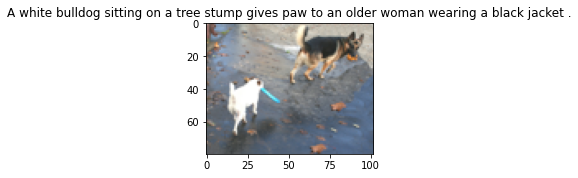

3033612929_764d977bd5.jpg


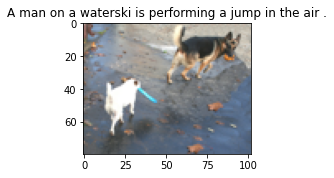

3033612929_764d977bd5.jpg


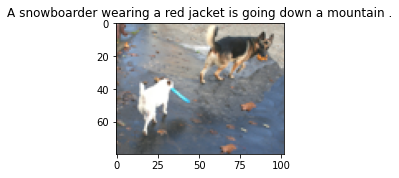

3033612929_764d977bd5.jpg


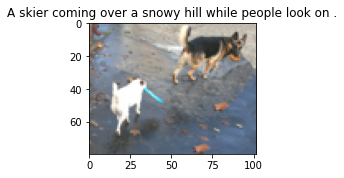

3033612929_764d977bd5.jpg


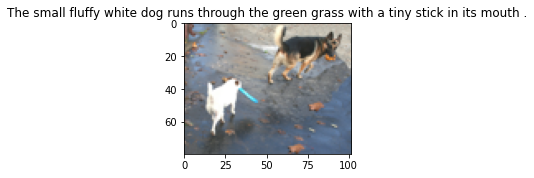

3033612929_764d977bd5.jpg


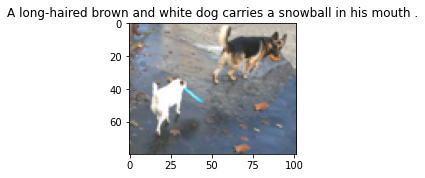

This image is anavailable in your country in compliance with local laws
3033612929_764d977bd5.jpg


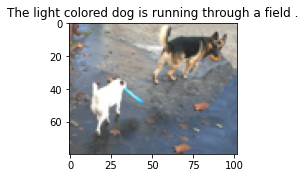

3033612929_764d977bd5.jpg


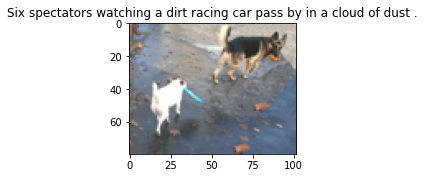

3033612929_764d977bd5.jpg


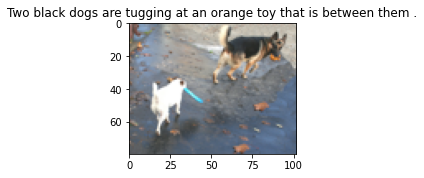

In [381]:
for item in test_queries_csv[['query_text']].sample(10).values:
    func(item[0])

## 8. Выводы

- [x]  Jupyter Notebook открыт
- [ ]  Весь код выполняется без ошибок
- [ ]  Ячейки с кодом расположены в порядке исполнения
- [ ]  Исследовательский анализ данных выполнен
- [ ]  Проверены экспертные оценки и краудсорсинговые оценки
- [ ]  Из датасета исключены те объекты, которые выходят за рамки юридических ограничений
- [ ]  Изображения векторизованы
- [ ]  Текстовые запросы векторизованы
- [ ]  Данные корректно разбиты на тренировочную и тестовую выборки
- [ ]  Предложена метрика качества работы модели
- [ ]  Предложена модель схожести изображений и текстового запроса
- [ ]  Модель обучена
- [ ]  По итогам обучения модели сделаны выводы
- [ ]  Проведено тестирование работы модели
- [ ]  По итогам тестирования визуально сравнили качество поиска